In [1]:
# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
# import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import utils, plot, cosmo
from holodeck.constants import MSOL, PC, YR, MPC, GYR, SPLC

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

In [2]:
gsmf = holo.sam.GSMF_Schechter()        # Galaxy Stellar-Mass Function (GSMF)
gpf = holo.sam.GPF_Power_Law()          # Galaxy Pair Fraction         (GPF)
gmt = holo.sam.GMT_Power_Law()          # Galaxy Merger Time           (GMT)
mmbulge = holo.sam.MMBulge_Simple()     # M-MBulge Relation            (MMB)

sam = holo.sam.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge)

In [40]:
# Choose observed GW-Frequency bins based on nyquist sampling
fobs = utils.nyquist_freqs(10.0*YR, 0.1*YR)

In [41]:
vals, weights, edges, dens, mass = holo.sam.sample_sam_with_hardening(
        sam, holo.evolution.Hard_GW, fobs=fobs,
        sample_threshold=5.0, cut_below_mass=3e7, limit_merger_time=4*GYR,
)

In [42]:
gwf_freqs, gwf, gwb = holo.sam._gws_from_samples(vals, weights, fobs)

In [43]:
gwb_smooth = sam.gwb(fobs, realize=False)
gwb_rough = sam.gwb(fobs, realize=100)

21:56:54 WARNING : FIX: bin centroids should be different for each bin, not just each dimension [sam.py:gwb]
21:57:01 WARNING : FIX: bin centroids should be different for each bin, not just each dimension [sam.py:gwb]


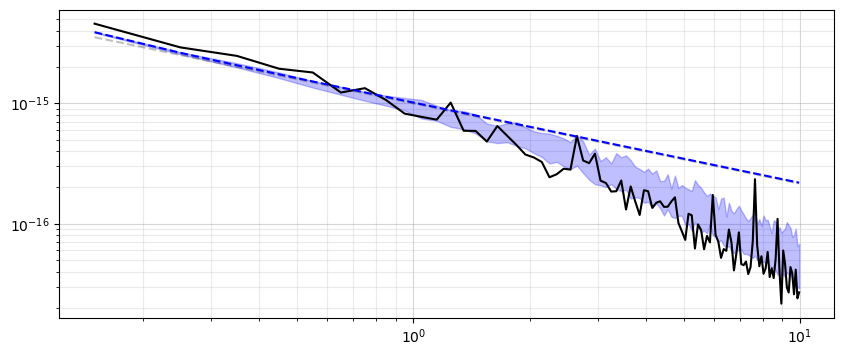

In [44]:
fig, ax = plot.figax()

xx = kale.utils.midpoints(fobs) * YR   # [1/sec] ==> [1/yr]

amp = 10e-16
yy = amp * np.power(xx, -2/3)
ax.plot(xx, yy, 'k--', alpha=0.25)

# ff = np.sqrt(xx / np.diff(fobs*YR))
ff = 1.0

ax.plot(xx, gwb*ff, 'k-')

idx = (gwf > gwb)
xx = gwf_freqs * YR   # [1/sec] ==> [1/yr]
ax.scatter(xx[idx], (gwf*ff)[idx], color='r', s=20, alpha=0.5)
ax.scatter(xx[~idx], (gwf*ff)[~idx], edgecolor='r', facecolor='none', s=20, alpha=0.5)

# ax.plot(fobs*YR, gwb_smooth, 'b--')
# ax.plot(fobs*YR, np.median(gwb_rough, axis=-1), 'b:')
ax.plot(xx, gwb_smooth, 'b--')
# ax.plot(xx, np.median(gwb_rough, axis=-1), 'b:')
# ax.plot(fobs*YR, np.mean(gwb_rough, axis=-1), 'b-.')
ax.fill_between(xx, *np.percentile(gwb_rough, [25, 75], axis=-1), color='b', alpha=0.25)

plt.show()

In [45]:
SAMP_NREALS = 100
gwb = np.zeros((fobs.size-1, SAMP_NREALS))
for ii in utils.tqdm(range(SAMP_NREALS)):
    gwf_freqs, gwf, _gwb = holo.sam.sampled_gws_from_sam(
        sam, fobs=fobs, hard=holo.evolution.Hard_GW, 
        sample_threshold=5.0, cut_below_mass=None, limit_merger_time=None,
    )
    gwb[:, ii] = np.sqrt(_gwb[:]**2 + gwf**2)

  0%|          | 0/100 [00:00<?, ?it/s]

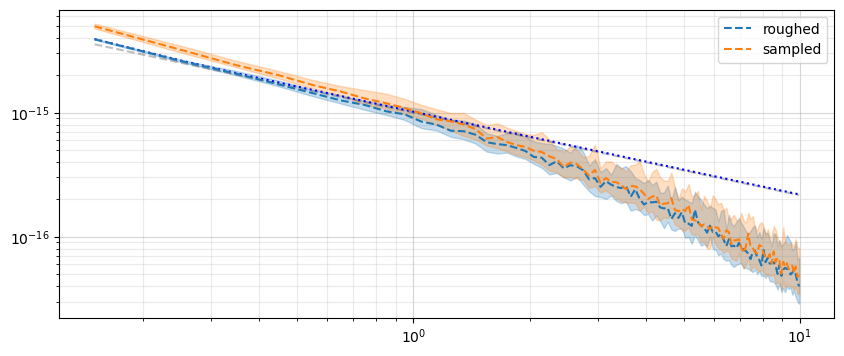

In [46]:
fig, ax = plot.figax()

def plot_gwb(xx, yy, **kwargs):
    cc, = ax.plot(xx, np.median(yy, axis=-1), ls='--', **kwargs)
    cc = cc.get_color()
    temp = np.percentile(yy, [25, 75], axis=-1)
    ax.fill_between(xx, *temp, color=cc, alpha=0.25)    
    return

xx = kale.utils.midpoints(fobs) * YR   # [1/sec] ==> [1/yr]

amp = 10e-16
yy = amp * np.power(xx, -2/3)
ax.plot(xx, yy, 'k--', alpha=0.25)

ax.plot(xx, gwb_smooth, 'b:')
plot_gwb(xx, gwb_rough, label='roughed')
if np.ndim(gwb) == 1:
    ax.plot(xx, gwb, 'k-', alpha=0.25)
else:
    plot_gwb(xx, gwb, label='sampled')

plt.legend()
plt.show()

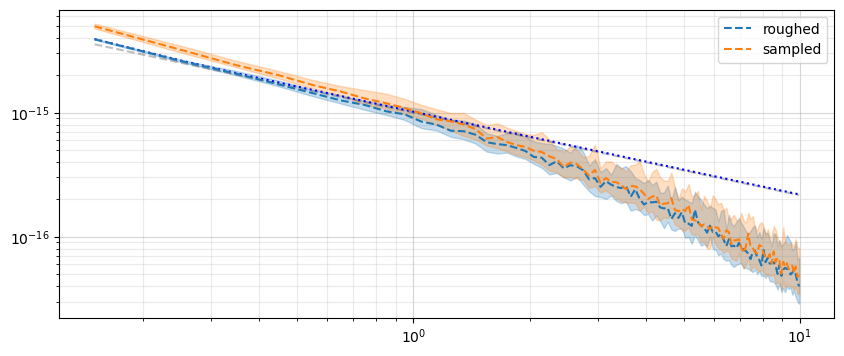

In [47]:
fig, ax = plot.figax()

def plot_gwb(xx, yy, **kwargs):
    cc, = ax.plot(xx, np.median(yy, axis=-1), ls='--', **kwargs)
    cc = cc.get_color()
    temp = np.percentile(yy, [25, 75], axis=-1)
    ax.fill_between(xx, *temp, color=cc, alpha=0.25)    
    return

xx = kale.utils.midpoints(fobs) * YR   # [1/sec] ==> [1/yr]

amp = 10e-16
yy = amp * np.power(xx, -2/3)
ax.plot(xx, yy, 'k--', alpha=0.25)

ax.plot(xx, gwb_smooth, 'b:')
plot_gwb(xx, gwb_rough, label='roughed')
plot_gwb(xx, gwb, label='sampled')

plt.legend()
plt.show()

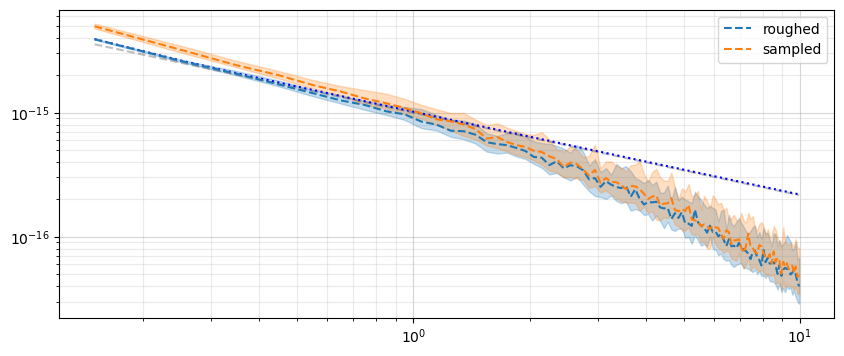

In [48]:
fig, ax = plot.figax()

def plot_gwb(xx, yy, **kwargs):
    cc, = ax.plot(xx, np.median(yy, axis=-1), ls='--', **kwargs)
    cc = cc.get_color()
    temp = np.percentile(yy, [25, 75], axis=-1)
    ax.fill_between(xx, *temp, color=cc, alpha=0.25)    
    return

xx = kale.utils.midpoints(fobs) * YR   # [1/sec] ==> [1/yr]

amp = 10e-16
yy = amp * np.power(xx, -2/3)
ax.plot(xx, yy, 'k--', alpha=0.25)

ax.plot(xx, gwb_smooth, 'b:')
plot_gwb(xx, gwb_rough, label='roughed')
plot_gwb(xx, gwb, label='sampled')

plt.legend()
plt.show()

# Manual

In [49]:
vals, weights, edges, dens, mass = holo.sam.sample_sam_with_hardening(
        sam, holo.evolution.Hard_GW, fobs=fobs,
        sample_threshold=5.0, cut_below_mass=None, limit_merger_time=None,
)

In [50]:
kale.utils.jshape(edges)

((4,), ((46,), (50,), (61,), (100,)))

In [51]:
counts, _ = np.histogramdd(vals.T, bins=edges, weights=weights)
print(counts.shape)

(45, 49, 60, 99)


In [52]:
import zcode
import zcode.math as zmath

(60, 99)
(60, 99)
extr=array([-0.30103   ,  8.82362914])


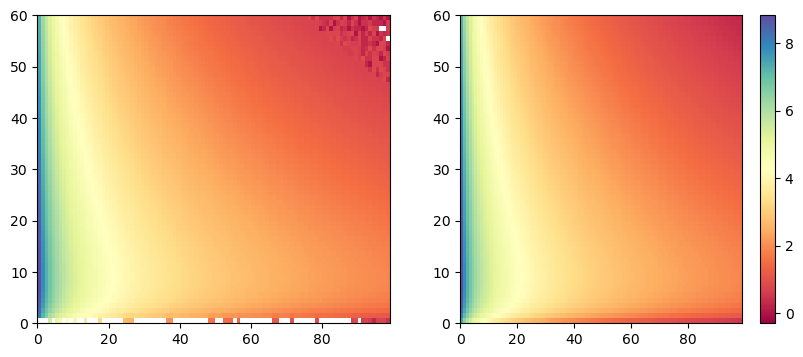

In [53]:
LOG = True
idx = (None, 0, 0, None)
print(counts[idx].squeeze().shape)
print(mass[idx].squeeze().shape)

fig, axes = plt.subplots(figsize=[10, 4], ncols=2)
extr = zmath.minmax(mass, prev=zmath.minmax(counts), limit=[0.5, None])
if LOG:
    extr = np.log10(extr)
smap = plot.smap(extr)
print(f"{extr=}")
for ii, (ax, qq) in enumerate(zip(axes, [counts, mass])):
    qq = qq[idx].squeeze()
    if LOG:
        qq = np.log10(qq)
    ax.pcolormesh(qq, cmap=smap.cmap, norm=smap.norm)
    
plt.colorbar(smap)
plt.show()

In [54]:
mc = utils.chirp_mass(*utils.m1m2_from_mtmr(vals[0], vals[1]))
rz = vals[2]
fo = vals[3]
frst = utils.frst_from_fobs(fo, rz)
dc = cosmo.comoving_distance(rz).cgs.value
hs = utils.gw_strain_source(mc, dc, frst)
print(hs.shape, fo.shape, weights.shape)

(3732963,) (3732963,) (3732963,)


In [55]:
idx = np.argsort(fo)
fo = fo[idx]
hs = hs[idx]
weights = weights[idx]

idx = np.digitize(fo, fobs) - 1
gwb = np.zeros(fobs.size-1)

for ii in utils.tqdm(range(gwb.size)):
    sel = (idx == ii)
    temp = weights[sel] * (hs[sel] ** 2)
    gwb[ii] = np.sum(temp)
    
gwb = np.sqrt(gwb)
print(gwb)

  0%|          | 0/99 [00:00<?, ?it/s]

[4.17548724e-15 1.90299916e-15 1.41535750e-15 8.91315010e-16
 7.38384323e-16 5.13409379e-16 4.65927360e-16 4.35385275e-16
 4.06483396e-16 5.68359454e-16 3.52010203e-16 2.39476663e-16
 2.02573430e-16 2.41558090e-16 2.27591401e-16 2.83732078e-16
 4.44546905e-16 1.32494858e-16 1.13294661e-16 1.14648825e-16
 2.19619320e-16 9.20512480e-17 6.45024270e-17 8.85951879e-17
 7.06814946e-17 5.56161446e-17 5.54469575e-17 9.21137929e-17
 4.07155006e-17 6.43706801e-17 2.85387436e-16 3.48865457e-17
 2.84512652e-17 5.36649991e-17 3.86984250e-17 3.40202688e-17
 4.44050084e-17 4.87926772e-17 7.80112126e-17 3.04621662e-17
 2.26361887e-17 2.28986432e-17 1.62382706e-17 1.77725709e-17
 2.21071579e-17 2.18722415e-17 3.96959129e-17 1.89187753e-17
 1.60058452e-17 3.00259023e-17 1.28261540e-17 2.02804369e-17
 9.71277621e-18 7.22069528e-17 1.29658177e-17 9.11843850e-18
 4.68662568e-17 2.23045747e-17 1.88589545e-17 1.64507821e-17
 1.43342639e-17 1.14685573e-17 1.38534813e-17 9.81266085e-17
 2.15852954e-17 1.035437

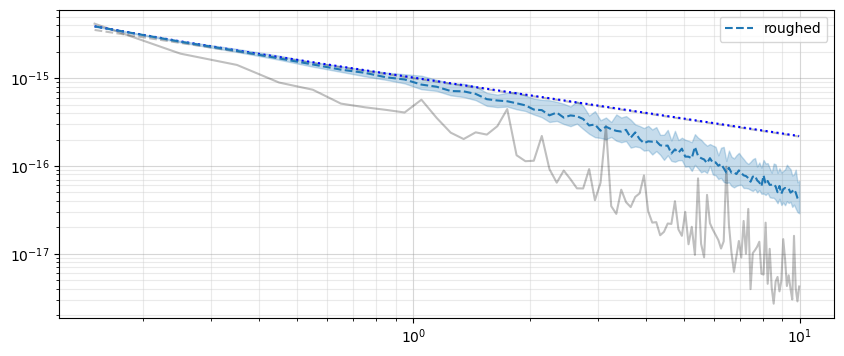

In [56]:
fig, ax = plot.figax()

def plot_gwb(xx, yy, **kwargs):
    cc, = ax.plot(xx, np.median(yy, axis=-1), ls='--', **kwargs)
    cc = cc.get_color()
    temp = np.percentile(yy, [25, 75], axis=-1)
    ax.fill_between(xx, *temp, color=cc, alpha=0.25)    
    return

xx = kale.utils.midpoints(fobs) * YR   # [1/sec] ==> [1/yr]

amp = 10e-16
yy = amp * np.power(xx, -2/3)
ax.plot(xx, yy, 'k--', alpha=0.25)
ax.plot(xx, gwb, 'k-', alpha=0.25)

ax.plot(xx, gwb_smooth, 'b:')
plot_gwb(xx, gwb_rough, label='roughed')
# plot_gwb(xx, gwb, label='sampled')

plt.legend()
plt.show()